In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction
from gta5_ import GTA5
from Cityscapes_clients import Cityscapes_clients
from Cityscapes import Cityscapes
from bisenetv2 import BiSeNetV2

In [35]:


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 12       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 120       # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

RESIZED_H = 256
RESIZED_W = 512

MODE = 'LOAD_AND_TRAIN'       #TRAIN or LOAD_AND_TRAIN or LOAD
MODEL_PATH = '/content/drive/My Drive/gta5.tar' #File to save the model in

Running on cpu


In [36]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]

normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])


#dataset = Cityscapes(...args..., 'A', 'heterogeneous', ...)
#dataset.set_client(0)
#loader = DataLoader(dataset, ...)


target_set = Cityscapes_clients('drive/MyDrive/', partition_type=['B','heterogeneous'], split='train', transform=eval_transform, target_transform=target_transform)
target_set.set_client(0) # 32 max
target_loader = DataLoader(target_set, batch_size=BATCH_SIZE, shuffle=True)



source_set = GTA5('drive/MyDrive/', transform=train_transform, target_transform=target_transform)
source_set = torch.utils.data.Subset(source_set, range(12))
source_loader = DataLoader(source_set, batch_size=BATCH_SIZE, shuffle=True)


In [37]:
len(source_set)

12

In [38]:
from FDA import FDA_source_to_target_np  
from PIL import Image
import scipy.misc

In [39]:

im_src, lbl_src = source_set.__getitem__(1)
im_trg, lbl_trg= target_set.__getitem__(1)

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.01 )

#src_in_trg = src_in_trg.transpose((1,2,0))
#scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0).save('drive/MyDrive/src_in_tar.png')

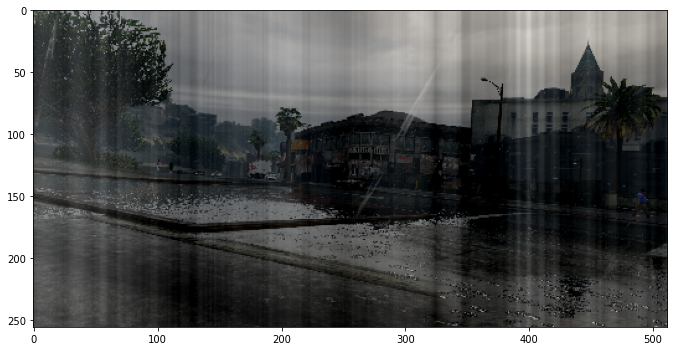

In [52]:
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
src_in_trg.numpy()
plt.imshow(src_in_trg.permute(2,0,1))
